# Lumigator from [Mozilla.ai](https://www.mozilla.ai/) 🐊 🦊

This Notebook will guide you through:

+ What Jupyter Notebooks are
+ An Overview of Machine Learning
+ The Lumigator Platform 🐊
+ How does a Machine Learning evaluation workflows looks like
+ The Thunderbird Ground Truth Dataset
+ Selecting models to perform summarization:
  + Using one encoder/decoder (BART)
  + Utilizing two decoders (Mistral and GPT-4) to evaluate against ground truth
+ Running evaluation experiments
+ Discussing results

## Jupyter Walkthrough

[Jupyter Notebooks](https://jupyter-notebook.readthedocs.io/en/stable/) provide an executable environment for running (usually) Python code alongside text. To work with Jupyter, click "Run Cell" to execute the code and view the results below the cell you are currently running. Cells are executed sequentially and can contain either text (Markdown) or Python code.

### Running cells 
To run a cell, press the "play" icon in the top bar (you can also hit Shift+Enter to run and proceed to the following cell).

<img src="https://raw.githubusercontent.com/mozilla-ai/lumigator/main/docs/assets/running.png" alt="drawing" width="400"/>

Your files are located on the left-hand side. They'll be saved for the duration of our session, but if you'd like to keep them, make sure to download them. 

<img src="https://raw.githubusercontent.com/mozilla-ai/lumigator/main/docs/assets/files.png" alt="drawing" width="400"/>

Lets' try running some code! Execute the following code and verify the output below.

In [1]:
print("Welcome to Lumigator!🐊")

Welcome to Lumigator!🐊


## Machine learning glossary

Some terms you'll hear us using throughout the session: 

+ **Machine learning** - The process of creating a model that learns from data
+ **Dataset** - Data used to train models and evaluate their performance
+ **LLM** - Large language model, [a text-based model that performs next-word predictions](https://www.nvidia.com/en-us/glossary/large-language-models/) 
+ **Tokens** - Words broken up into pieces to be used in an LLM 
+ **Inference** - The process of getting a prediction from a large language model 
+ **Embeddings** - Numerical representations of text generated by modeling 
+ **Encoder-decoder models** - A neural network architecture comprised of two neural networks, an encoder that takes the input vectors from our data and creates an embedding of a fixed length, and a decoder, also a neural network, which takes the embeddings encoded as input and generates a static set of outputs such as translated text or a text summary
+ **Decoder-only models** - Given a fixed input prompt, uses its representation to generate a sequence of words one at a time, with each word being conditioned on the ones generated previously
+ **Task** - Machine learning tasks to fit a specific model type, including translation, summarization, completion, etc. 
+ **Ground truth** - Information that has been evaluated to be true by humans (or LLMs, in some cases), that we can use to evaluate and compare trained models. 

The process of **machine learning** is the process of creating a mathematical model that tries to approximate the world. A **machine learning model** is a set of instructions for generating a given
output from data. The instructions are learned from the features of the input data itself.

Within the universe of modeling approaches, there are **supervised** and **unsupervised** approaches, as well as reinforcement learning. 
Language modeling of the kind we do with LLMs falls in the realm of neural network approaches. 

<img src="https://raw.githubusercontent.com/mozilla-ai/lumigator/main/docs/assets/ml_family.png" alt="drawing" width="400"/>

### How do LLMs work? 

There are many different kinds of LLMs and many different kinds of architectures. For our evaluations, we use two different kinds:

+ **Encoder/Decoder** - BART is an encoder/decoder model that converts input data into a fixed-size representation (similar to encoder models). These models are trained first to transform text into numerical representations, then to output text based on those numerical representations. They're good for synthesis as opposed to generation. 
+ **Decoder-only** - most GPT-family models, like Mistral, GPT, and others we'll be working with, are pre-trained with text data in an autoregressive manner, for next-token prediction given previous tokens.  

### LLM Evaluation Workflows

The following steps outline the phases that an LLM goes through during evaluation:

1. Generate ground truth for our business use-case
1. Pick several models we'd like to use to evaluate
1. Run an evaluation loop consisting of looking at the ground truth in comparison to model output
1. Analyze the evaluation results

<img src="https://raw.githubusercontent.com/mozilla-ai/lumigator/main/docs/assets/llm_steps.png" alt="drawing" width="600"/>

Lumigator on a technical level is a **Python-based FastAPI web app** with services that run **jobs and deployments on a Ray cluster**, which can be run either locally or in the cloud, depending on your computer specs. Results and job metadata are stored in an SQL database. Larger models loaded from [HuggingFace](https://huggingface.co/) require GPUs.  

<img src="https://raw.githubusercontent.com/mozilla-ai/lumigator/main/docs/assets/platform.png" alt="drawing" width="400"/>

What is Ray? [A distributed runtime for Python programs](https://github.com/ray-project/ray) that includes a Core library with primitives (Tasks, Actors, and objects) and a suite of ML libraries (Tune, Serve) that allow to build components of the machine learning model workflow. 

### Nota bene: Machine learning is alchemy

When we think of traditional software application workflows, we think of an example such as adding a button. We can clearly test that we've added a blue button to our application, and that it works correctly. Machine learning is not like this! It involves a lot of experimentation, tweaking of hyperparameters and prompts and trying different models. Expect for the process to be imperfect, with many iterative loops. Luckily, Lumigator helps take away the uncertainty of at least model selection. 🙂

> There’s a self-congratulatory feeling in the air. We say things like “machine learning is the new electricity”. I’d like to offer an alternative metaphor: machine learning has become alchemy. - [Ben Recht and Ali Rahimi](https://archives.argmin.net/2017/12/05/kitchen-sinks/)

Ultimately, the final conclusion of whether a model is good is if humans think it's good. 

With that in mind, let's dive into setting up experiments with Lumigator to test our models!

In [32]:
# Importing packages we need to work with data 
# python standard libraries
import os
import time
import json

# Random string generator
import random
import string
import shortuuid

# third-party libraries
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset
from IPython.display import clear_output

from lumigator_sdk.lumigator import LumigatorClient
from lumigator_schemas.datasets import DatasetFormat
from lumigator_schemas.experiments import ExperimentCreate

# wrap columns for inspection
pd.set_option('display.max_colwidth', 0)
# stylesheet for visibility
plt.style.use("fast")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Understanding the Lumigator App and API 

The app itself consists of an API, which you can access and test out methods in the [OpenAPI spec](https://swagger.io/specification/), at the platform URL, under docs.
If you are running Lumigator as a local installation, you can directly access the API at [this URL](http://localhost:8000/docs).

<img src="https://raw.githubusercontent.com/mozilla-ai/lumigator/main/docs/assets/openapi.png" alt="drawing" width="200"/>

Large language models today are consumed in one of several ways:

+ As **API endpoints** for proprietary models hosted by [OpenAI](https://openai.com/), [Anthropic](https://www.anthropic.com/), or major cloud providers
+ As **model artifacts** downloaded from HuggingFace’s Model Hub and/or trained/fine-tuned using HuggingFace libraries and hosted on local storage
+ As model artifacts available in a format optimized for **local inference**, typically [GGUF](https://github.com/ggerganov/ggml/blob/master/docs/gguf.md), and accessed via applications like [llama.cpp](https://github.com/ggerganov/llama.cpp) or [ollama](https://ollama.com/)
+ As [ONNX](https://onnx.ai/), a format which optimizes sharing between backend ML frameworks

We use API endpoints and local storage in Lumigator. We currently have 5 key endpoints on the platform:

+ `Health` - Status of the application, running status of jobs and deployments. 
+ `Datasets` - Data that we add to the platform for evaluation. We can upload, delete, and save different data in the platform. - We'll use this to save our ground truth and experiment data
+ `Jobs` - Our actual evaluation experiments. We can list all previous evaluations, create new ones, and get their results.
+ `Completions` - Access to external APIs such as Mistral and OpenAI

## Model Task: Summarization

The task we'll be working with is **summarization**, aka we want to generate a summary of our text. 

In our business case, which is to create summaries of conversation threads, much as you might see in Slack or an email chain, the models need to be able to extract key information from those threads while still being able to accept a large context window to capture the entire conversation history. 

We identified that it is far more valuable to conduct **abstractive** summaries—summaries that identify important sections in the text and generate highlights—rather than **extractive** ones, which select a subset of sentences and staple them together. This is because the final interface will be in natural language, and we want to avoid summaries that are interpreted from often incoherent text snippets produced by extractive methods.

For more on summarization as a use-case, [see our blog post here.](https://blog.mozilla.ai/on-model-selection-for-text-summarization/)

## Ground Truth for Models

The term ground truth comes from geology and geospatial sciences, where actual information was collected on the ground to validate data acquired through remote sensing, such as satellite imagery or aerial photography. Since then, the concept has been adopted in other fields, particularly in machine learning and artificial intelligence, to refer to the accurate, real-world data used for training and testing models. 

The **best ground truth is human-generated** but building it is a very expensive task. One recent trend is to rely on large language models but (as you will see later) they have their own pitfalls. An intermediate approach uses different LLMs to provide ground truth "candidates" which are then subject to human pairwise evaluation.

## Our Input data

The data we'll be using in this walkthrough comes from [DialogSum](https://github.com/cylnlp/DialogSum), a large-scale labeled dialogue summarization dataset which comes with ground truth provided by human annotators.

For the sake of explanation, in the next section we will show how Lumigator allows one to generate a ground truth candidates with the help of a language model. However, in the following evaluation section we will compare against the original, human-provided, annotations.

Here follows a brief description of DialogSum.

In [3]:
# The dataset is available at https://huggingface.co/datasets/knkarthick/dialogsum
# and can be directly downloaded with the `load_dataset` method
dataset = 'knkarthick/dialogsum'
ds = load_dataset(dataset, split='validation')
df = ds.to_pandas()

In [4]:
# Examine a single sample 
df['dialogue'].iloc[0]

"#Person1#: Hello, how are you doing today?\n#Person2#: I ' Ve been having trouble breathing lately.\n#Person1#: Have you had any type of cold lately?\n#Person2#: No, I haven ' t had a cold. I just have a heavy feeling in my chest when I try to breathe.\n#Person1#: Do you have any allergies that you know of?\n#Person2#: No, I don ' t have any allergies that I know of.\n#Person1#: Does this happen all the time or mostly when you are active?\n#Person2#: It happens a lot when I work out.\n#Person1#: I am going to send you to a pulmonary specialist who can run tests on you for asthma.\n#Person2#: Thank you for your help, doctor."

In [5]:
# Add a function to do some simple character counts for model input
df['char_count'] = df['dialogue'].str.len()

In [6]:
# inspect our data
df.head(n=3)

,id,dialogue,summary,topic,char_count
0,dev_0,"#Person1#: Hello, how are you doing today?\n#Person2#: I ' Ve been having trouble breathing lately.\n#Person1#: Have you had any type of cold lately?\n#Person2#: No, I haven ' t had a cold. I just have a heavy feeling in my chest when I try to breathe.\n#Person1#: Do you have any allergies that you know of?\n#Person2#: No, I don ' t have any allergies that I know of.\n#Person1#: Does this happen all the time or mostly when you are active?\n#Person2#: It happens a lot when I work out.\n#Person1#: I am going to send you to a pulmonary specialist who can run tests on you for asthma.\n#Person2#: Thank you for your help, doctor.",#Person2# has trouble breathing. The doctor asks #Person2# about it and will send #Person2# to a pulmonary specialist.,see a doctor,622
1,dev_1,"#Person1#: Hey Jimmy. Let's go workout later today.\n#Person2#: Sure. What time do you want to go?\n#Person1#: How about at 3:30?\n#Person2#: That sounds good. Today we work on Legs and forearm.\n#Person1#: Hey. I just played basketball earlier, so my legs are a little sore. Let's work out on arms and stomach today.\n#Person2#: I'm on a weekly schedule. You're messing everything up.\n#Person1#: C'mon. We're only switching two days. You can do legs on Friday.\n#Person2#: Aright. I'll meet you at the gym at 3:30 then.",#Person1# invites Jimmy to go workout and persuades him into working out on arms and stomach.,do exercise,514
2,dev_2,"#Person1#: I need to stop eating such unhealthy foods.\n#Person2#: I know what you mean. I've started eating better myself.\n#Person1#: What foods do you eat now?\n#Person2#: I tend to stick to fruits, vegetables, and chicken.\n#Person1#: Those are the only things you eat?\n#Person2#: That's basically what I eat.\n#Person1#: Why aren't you eating anything else?\n#Person2#: Well, fruits and vegetables are very healthy.\n#Person1#: And the chicken?\n#Person2#: It's really healthy to eat when you bake it.\n#Person1#: I guess that does sound a lot healthier.","#Person1# plans to stop eating unhealthy foods, and #Person2# shares #Person2#'s healthy recipe with #Person1#.",healthy foods,550


In [7]:
# Show statistics about characters count
df['char_count'].describe()

count    500.000000 
mean     727.386000 
std      366.971931 
min      211.000000 
25%      477.000000 
50%      642.500000 
75%      912.500000 
max      2563.000000
Name: char_count, dtype: float64

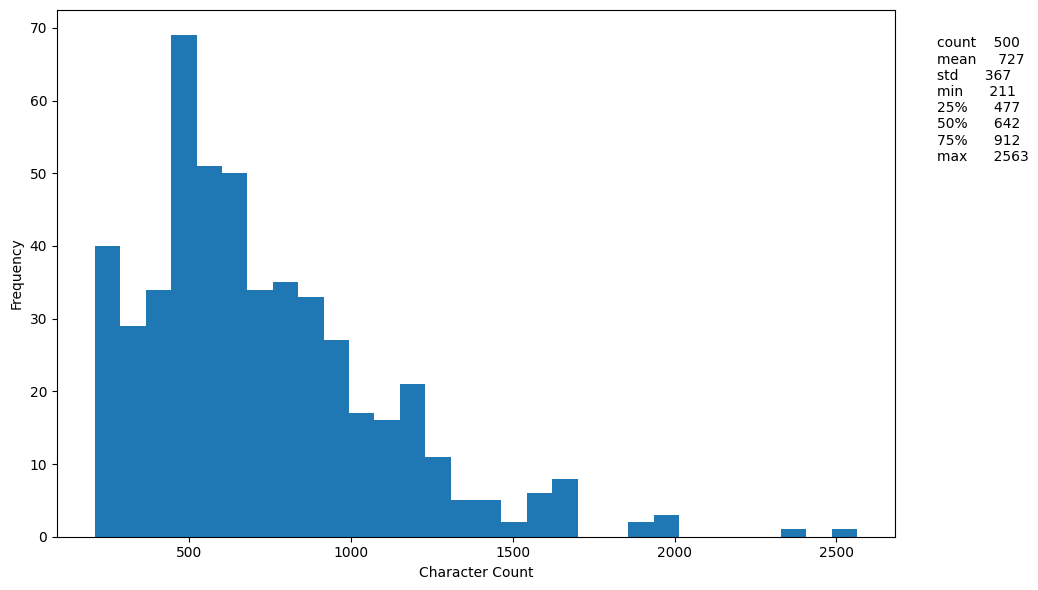

In [8]:
# Generate plot of character counts
fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(df['char_count'], bins=30)
ax.set_xlabel('Character Count')
ax.set_ylabel('Frequency')

stats = df['char_count'].describe().apply(lambda x: f"{x:.0f}")

# Add text boxes for statistics
plt.text(1.05, 0.95, stats.to_string(), 
         transform=ax.transAxes, verticalalignment='top')

# Adjust layout
plt.tight_layout()
fig.subplots_adjust(right=0.75)

plt.show()

## Ground Truth Generation with Mistral

In the following we will use [Mistral API](https://docs.mistral.ai/api/) to generate candidate ground truth. Note that for the following code to work, you need to have a valid mistral API key (no worries if you don't, the next section shows another methods which relies on an opensource model running locally on your computer).

In [9]:
from lumigator_sdk.lumigator import LumigatorClient

lm_client = LumigatorClient(f"{os.getenv('LUMIGATOR_SERVICE_HOST', 'localhost')}:8000")

2024-10-25 14:42:25.598 | INFO     | lumigator_sdk.client:_make_request:54 - [
  "mistral",
  "openai"
]


In [10]:
# Perform Ground Truth Generation with Mistral
vendor = "mistral"
mistral_responses = []

for sample in df['dialogue'][0:10]:
    res = lm_client.completions.get_completion(vendor, sample)
    print(f"Mistral Summary:", res)
    mistral_responses.append((sample, res.text))

{"text": "#Person1#: Hello, how are you doing today?\n#Person2#: I ' Ve been having trouble breathing lately.\n#Person1#: Have you had any type of cold lately?\n#Person2#: No, I haven ' t had a cold. I just have a heavy feeling in my chest when I try to breathe.\n#Person1#: Do you have any allergies that you know of?\n#Person2#: No, I don ' t have any allergies that I know of.\n#Person1#: Does this happen all the time or mostly when you are active?\n#Person2#: It happens a lot when I work out.\n#Person1#: I am going to send you to a pulmonary specialist who can run tests on you for asthma.\n#Person2#: Thank you for your help, doctor."}


2024-10-25 14:42:29.772 | INFO     | lumigator_sdk.client:_make_request:54 - {
  "text": "The person shares they've been experiencing breathing difficulties without a recent cold, and the issue is more pronounced during exercise, suggesting potential asthma. The other person suggests consulting a pulmonary specialist for further tests."
}


Mistral Summary: text="The person shares they've been experiencing breathing difficulties without a recent cold, and the issue is more pronounced during exercise, suggesting potential asthma. The other person suggests consulting a pulmonary specialist for further tests."
{"text": "#Person1#: Hey Jimmy. Let's go workout later today.\n#Person2#: Sure. What time do you want to go?\n#Person1#: How about at 3:30?\n#Person2#: That sounds good. Today we work on Legs and forearm.\n#Person1#: Hey. I just played basketball earlier, so my legs are a little sore. Let's work out on arms and stomach today.\n#Person2#: I'm on a weekly schedule. You're messing everything up.\n#Person1#: C'mon. We're only switching two days. You can do legs on Friday.\n#Person2#: Aright. I'll meet you at the gym at 3:30 then."}


2024-10-25 14:42:30.739 | INFO     | lumigator_sdk.client:_make_request:54 - {
  "text": "Person 1 proposes a workout session later in the day and suggests 3:30 as the time. Person 1 mentions feeling sore from basketball and suggests working on arms and stomach instead, to which Person 2 initially objects but eventually agrees to meet at 3:30."
}


Mistral Summary: text='Person 1 proposes a workout session later in the day and suggests 3:30 as the time. Person 1 mentions feeling sore from basketball and suggests working on arms and stomach instead, to which Person 2 initially objects but eventually agrees to meet at 3:30.'
{"text": "#Person1#: I need to stop eating such unhealthy foods.\n#Person2#: I know what you mean. I've started eating better myself.\n#Person1#: What foods do you eat now?\n#Person2#: I tend to stick to fruits, vegetables, and chicken.\n#Person1#: Those are the only things you eat?\n#Person2#: That's basically what I eat.\n#Person1#: Why aren't you eating anything else?\n#Person2#: Well, fruits and vegetables are very healthy.\n#Person1#: And the chicken?\n#Person2#: It's really healthy to eat when you bake it.\n#Person1#: I guess that does sound a lot healthier."}


2024-10-25 14:42:32.279 | INFO     | lumigator_sdk.client:_make_request:54 - {
  "text": "Person1 expresses a desire to stop consuming unhealthy foods, and Person2 shares their own journey towards eating healthier, primarily focusing on fruits, vegetables, and baked chicken."
}


Mistral Summary: text='Person1 expresses a desire to stop consuming unhealthy foods, and Person2 shares their own journey towards eating healthier, primarily focusing on fruits, vegetables, and baked chicken.'
{"text": "#Person1#: Do you believe in UFOs?\n#Person2#: Of course, they are out there.\n#Person1#: But I never saw them.\n#Person2#: Are you stupid? They are called UFOs, so not everybody can see them.\n#Person1#: You mean that you can them.\n#Person2#: That's right. I can see them in my dreams.\n#Person1#: They come to the earth?\n#Person2#: No. Their task is to send the aliens here from the outer space.\n#Person1#: Aliens from the outer space? Do you talk to them? What do they look like?\n#Person2#: OK, OK, one by one, please! They look like robots, but they can speak. Their mission is to make friends with human beings.\n#Person1#: That means that you talk to them? In which language?\n#Person2#: Of course in English, they learn English on Mars too.\n#Person1#: Wow. Sounds fant

2024-10-25 14:42:34.457 | INFO     | lumigator_sdk.client:_make_request:54 - {
  "text": "Person1 is skeptical about UFOs, having never seen one, while Person2 believes in UFOs and claims to see them in dreams. Person2 also believes that these UFOs bring aliens from outer space, who look like robots and communicate in English, as they learn it on Mars."
}


Mistral Summary: text='Person1 is skeptical about UFOs, having never seen one, while Person2 believes in UFOs and claims to see them in dreams. Person2 also believes that these UFOs bring aliens from outer space, who look like robots and communicate in English, as they learn it on Mars.'
{"text": "#Person1#: Did you go to school today?\n#Person2#: Of course. Did you?\n#Person1#: I didn't want to, so I didn't.\n#Person2#: That's sad, but have you gone to the movies recently?\n#Person1#: That's a switch.\n#Person2#: I'm serious, have you?\n#Person1#: No, I haven't. Why?\n#Person2#: I really want to go to the movies this weekend.\n#Person1#: So go then.\n#Person2#: I really don't want to go by myself.\n#Person1#: Well anyway, do you plan on going to school tomorrow?\n#Person2#: No, I think I'm going to go to the movies."}


2024-10-25 14:42:37.399 | INFO     | lumigator_sdk.client:_make_request:54 - {
  "text": "Person 1 skips school due to not wanting to go, and neither of them have gone to the movies recently. Person 2 expresses a desire to go to the movies this weekend but doesn't want to go alone."
}


Mistral Summary: text="Person 1 skips school due to not wanting to go, and neither of them have gone to the movies recently. Person 2 expresses a desire to go to the movies this weekend but doesn't want to go alone."
{"text": "#Person1#: Honey, I think you should quit smoking.\n#Person2#: Why? You said I was hot when smoking.\n#Person1#: But I want you to be fit.\n#Person2#: Smoking is killing. I know.\n#Person1#: Check out this article. It says smoking can lead to lung cancer.\n#Person2#: I don't believe it.\n#Person1#: But you know that smoking does harm to health, right?\n#Person2#: Of course I know it, but you know it's hard to quit smoking. . .\n#Person1#: Stop beating around the bush. Will you quit or not?\n#Person2#: Yes, ma'am. Whatever you say."}


2024-10-25 14:42:38.420 | INFO     | lumigator_sdk.client:_make_request:54 - {
  "text": "Person1 expresses concern over Partner2's smoking and encourages them to quit for health reasons, citing potential harm and lung cancer risks. Despite acknowledging the health issues, Partner2 finds quitting challenging and eventually accepts Person1's request."
}


Mistral Summary: text="Person1 expresses concern over Partner2's smoking and encourages them to quit for health reasons, citing potential harm and lung cancer risks. Despite acknowledging the health issues, Partner2 finds quitting challenging and eventually accepts Person1's request."
{"text": "#Person1#: Excuse me, Mr. White? I just need you to sign these before I leave.\n#Person2#: Sure, Sherry. Sorry to have kept you waiting. If you hadn't told me, I probably would have just forgotten all about them.\n#Person1#: That's my job, sir. Just one more signature here, please.\n#Person2#: There you are."}


2024-10-25 14:42:39.444 | INFO     | lumigator_sdk.client:_make_request:54 - {
  "text": "Person1 requests Mr. White to sign some documents before leaving, explaining that it's part of her job. Mr. White apologizes for the delay, mentions forgetting the documents, and signs as requested."
}


Mistral Summary: text="Person1 requests Mr. White to sign some documents before leaving, explaining that it's part of her job. Mr. White apologizes for the delay, mentions forgetting the documents, and signs as requested."
{"text": "#Person1#: Hey, Karen. Look like you got some sun this weekend.\n#Person2#: Yeah? I guess so. I spent the weekend at beach.\n#Person1#: That's great. Where did you stay?\n#Person2#: Some friends of my parents live out there, and they invited me there.\n#Person1#: So, what did you do out there? I mean besides bask in the sun, obviously.\n#Person2#: I jogged up and down the beach and played volleyball. You know I never realized how hard it is to run on sand. I couldn't get through a whole game before I had to sit down.\n#Person1#: Not to mention cooler. Did you go swimming?\n#Person2#: I wanted to, but the water is too cold, and I just wetted in up to my knees.\n#Person1#: It all sounds so relaxing. I wish I could get away to the beach like that.\n#Person2#: 

2024-10-25 14:42:41.080 | INFO     | lumigator_sdk.client:_make_request:54 - {
  "text": "Person 2 spent the weekend at the beach with friends, enjoying activities like jogging and volleyball. Despite the cold water, they only waded up to their knees for a swim. Person 1 expressed their wish to escape to the beach after hearing about Person 2's relaxing getaway, implying they had a less enjoyable weekend."
}


Mistral Summary: text="Person 2 spent the weekend at the beach with friends, enjoying activities like jogging and volleyball. Despite the cold water, they only waded up to their knees for a swim. Person 1 expressed their wish to escape to the beach after hearing about Person 2's relaxing getaway, implying they had a less enjoyable weekend."
{"text": "#Person1#: How do you usually spend your leisure time? I mean, do you have any special interests out of your job?\n#Person2#: Of course. You see, almost everyone has some kind of hobby\n#Person1#: Yeah, you're quite right and what's your hobby?\n#Person2#: I like taking photos out of door.\n#Person1#: Oh, photography, It's really a good hobby.\n#Person2#: Yes, I usually develop and print all my own photos.\n#Person1#: You yourself have a photo studio?\n#Person2#: Yes, simple as it is. It does work."}


2024-10-25 14:42:42.376 | INFO     | lumigator_sdk.client:_make_request:54 - {
  "text": "Person1 inquired about Person2's leisure activities, and Person2 revealed that they enjoy outdoor photography and develop their own photos in a simple home studio."
}


Mistral Summary: text="Person1 inquired about Person2's leisure activities, and Person2 revealed that they enjoy outdoor photography and develop their own photos in a simple home studio."
{"text": "#Person1#: have you ever seen Bill Gate's home on the internet?\n#Person2#: no. what's it like?\n#Person1#: it's got its own library, theatre, swimming pool, and a guest house. The house itself has about ten different rooms that are all hooked up to computers so you can get things done in each room through.\n#Person2#: would you want to live there?\n#Person1#: I think his house is fantastic, but I wouldn't want to live there. You would have to hire one or two people to clean all the rooms in the house, plus a few people to take care of the gardens.\n#Person2#: what's your dream home like then?\n#Person1#: my dream home is actually just a small cottage in a quite village in England.\n#Person2#: would you want to buy an old cottage or build a new one yourself?\n#Person1#: old homes are great b

2024-10-25 14:42:43.953 | INFO     | lumigator_sdk.client:_make_request:54 - {
  "text": "Person 1 describes Bill Gates' home as a large estate with a library, theater, swimming pool, guest house, and computer-equipped rooms in each room. They prefer a small cottage in a quiet English village as their dream home, appreciating the character of old houses and opting for second-hand clothes due to financial reasons. If they lived in an old house, they would aim to restore it to its original state."
}


Mistral Summary: text="Person 1 describes Bill Gates' home as a large estate with a library, theater, swimming pool, guest house, and computer-equipped rooms in each room. They prefer a small cottage in a quiet English village as their dream home, appreciating the character of old houses and opting for second-hand clothes due to financial reasons. If they lived in an old house, they would aim to restore it to its original state."


In [11]:
# Let's create a result set we can look at
mistral_results_df = pd.DataFrame(mistral_responses, columns=['examples', 'mistral_response'])
mistral_results_df

,examples,mistral_response
0,"#Person1#: Hello, how are you doing today?\n#Person2#: I ' Ve been having trouble breathing lately.\n#Person1#: Have you had any type of cold lately?\n#Person2#: No, I haven ' t had a cold. I just have a heavy feeling in my chest when I try to breathe.\n#Person1#: Do you have any allergies that you know of?\n#Person2#: No, I don ' t have any allergies that I know of.\n#Person1#: Does this happen all the time or mostly when you are active?\n#Person2#: It happens a lot when I work out.\n#Person1#: I am going to send you to a pulmonary specialist who can run tests on you for asthma.\n#Person2#: Thank you for your help, doctor.","The person shares they've been experiencing breathing difficulties without a recent cold, and the issue is more pronounced during exercise, suggesting potential asthma. The other person suggests consulting a pulmonary specialist for further tests."
1,"#Person1#: Hey Jimmy. Let's go workout later today.\n#Person2#: Sure. What time do you want to go?\n#Person1#: How about at 3:30?\n#Person2#: That sounds good. Today we work on Legs and forearm.\n#Person1#: Hey. I just played basketball earlier, so my legs are a little sore. Let's work out on arms and stomach today.\n#Person2#: I'm on a weekly schedule. You're messing everything up.\n#Person1#: C'mon. We're only switching two days. You can do legs on Friday.\n#Person2#: Aright. I'll meet you at the gym at 3:30 then.","Person 1 proposes a workout session later in the day and suggests 3:30 as the time. Person 1 mentions feeling sore from basketball and suggests working on arms and stomach instead, to which Person 2 initially objects but eventually agrees to meet at 3:30."
2,"#Person1#: I need to stop eating such unhealthy foods.\n#Person2#: I know what you mean. I've started eating better myself.\n#Person1#: What foods do you eat now?\n#Person2#: I tend to stick to fruits, vegetables, and chicken.\n#Person1#: Those are the only things you eat?\n#Person2#: That's basically what I eat.\n#Person1#: Why aren't you eating anything else?\n#Person2#: Well, fruits and vegetables are very healthy.\n#Person1#: And the chicken?\n#Person2#: It's really healthy to eat when you bake it.\n#Person1#: I guess that does sound a lot healthier.","Person1 expresses a desire to stop consuming unhealthy foods, and Person2 shares their own journey towards eating healthier, primarily focusing on fruits, vegetables, and baked chicken."
3,"#Person1#: Do you believe in UFOs?\n#Person2#: Of course, they are out there.\n#Person1#: But I never saw them.\n#Person2#: Are you stupid? They are called UFOs, so not everybody can see them.\n#Person1#: You mean that you can them.\n#Person2#: That's right. I can see them in my dreams.\n#Person1#: They come to the earth?\n#Person2#: No. Their task is to send the aliens here from the outer space.\n#Person1#: Aliens from the outer space? Do you talk to them? What do they look like?\n#Person2#: OK, OK, one by one, please! They look like robots, but they can speak. Their mission is to make friends with human beings.\n#Person1#: That means that you talk to them? In which language?\n#Person2#: Of course in English, they learn English on Mars too.\n#Person1#: Wow. Sounds fantastic!","Person1 is skeptical about UFOs, having never seen one, while Person2 believes in UFOs and claims to see them in dreams. Person2 also believes that these UFOs bring aliens from outer space, who look like robots and communicate in English, as they learn it on Mars."
4,"#Person1#: Did you go to school today?\n#Person2#: Of course. Did you?\n#Person1#: I didn't want to, so I didn't.\n#Person2#: That's sad, but have you gone to the movies recently?\n#Person1#: That's a switch.\n#Person2#: I'm serious, have you?\n#Person1#: No, I haven't. Why?\n#Person2#: I really want to go to the movies this weekend.\n#Person1#: So go then.\n#Person2#: I really don't want to go by myself.\n#Person1#: Well anyway, do you plan on going to school tomorrow?\n#Person2#: No

## Ground Truth Generation with a local model

In this section we will use a local model to generate ground truth.

To do this, you will spin up a new _ray deployment_ from Lumigator's API. You can do it manually by connecting to the API and submitting the following JSON to the `/api/v1/ground-truth/deployments` endpoint:

```
{
  "num_gpus": 0,
  "num_cpus": 1,
  "num_replicas": 1
}
```
... or you can copy and paste the following into your terminal to send the same request to the API via `curl`:

```
curl -X 'POST' \
  'http://localhost/api/v1/ground-truth/deployments' \
  -H 'accept: application/json' \
  -H 'Content-Type: application/json' \
  -d '{
  "num_gpus": 0,
  "num_cpus": 1,
  "num_replicas": 1
}'
```

After this, you can run the following cell to see information about your new deployment. Also note that you can get more details about it on your [ray dashboard](http://localhost:8265/#/actors).

In [ ]:
# Let's take a look at all available deployments
ld.get_deployments()

In [ ]:
# Perform Ground Truth Generation with BART

deployment_id = ld.get_summarizer_deployment_id()

bart_responses = []

for prompt in df['dialogue'][0:10]:
    response = ld.get_bart_ground_truth(deployment_id, prompt)
    response_dict = json.loads(response.text)
    results = response_dict.get('deployment_response', {}).get('result', 'No result found')
    print("BART:", results)
    bart_responses.append((prompt, results))

In [ ]:
bart_results_df = pd.DataFrame(bart_responses, columns=['examples', 'bart_response'])
bart_results_df

In [ ]:
# Combine results and examine multiple versions of ground truth
merged_df = pd.merge(bart_results_df, mistral_results_df, on='examples', how='outer')
merged_df.to_csv('ground_truth.csv', index=False)
merged_df 

## Save and upload datasets

Now that you have seen the different available options to generate ground truth, let us save all datasets and make them available to lumigator for further experiments.

For each example (dialogsum original dataset, bart-generated gt, mistral-generated gt) we will perform the following operations:

1. Make sure that the two main fields (original text and ground truth) are called `examples` and `ground_truth`, which are the names internally used by Lumigator to refer to them, and save the datasets as CSV files.

2. Make the dataset available to Lumigator with the `dataset_upload` method. If you are running locally the term "upload" might not make much sense to you, but it does if you think about it as a system which can work in a distributed fashion: with this method, your data is accessed locally or on a remote S3 store depending on the setup, in a way which is consistent and transparent to users.

In [12]:
ds = ds.remove_columns(["id", "topic"])
ds = ds.rename_column("dialogue", "examples")
ds = ds.rename_column("summary", "ground_truth")

dataset_name = "dialogsum_converted.csv"
ds.to_csv(dataset_name)

Creating CSV from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

430961

In [16]:
lm_client.datasets.create_dataset(
    open(dataset_name, "rb"),
    DatasetFormat.EXPERIMENT
)

2024-10-25 15:19:50.173 | INFO     | lumigator_sdk.client:_make_request:54 - {
  "id": "8a028464-2afd-4f23-9289-2af3dc9f3580",
  "filename": "dialogsum_converted.csv",
  "format": "experiment",
  "size": 430961,
  "ground_truth": true,
  "created_at": "2024-10-25T12:19:49"
}


DatasetResponse(id=UUID('8a028464-2afd-4f23-9289-2af3dc9f3580'), filename='dialogsum_converted.csv', format=<DatasetFormat.EXPERIMENT: 'experiment'>, size=430961, ground_truth=True, created_at=datetime.datetime(2024, 10, 25, 12, 19, 49))

In [ ]:
bart_results_df = bart_results_df.rename(columns={"bart_response": "ground_truth"})
bart_results_df.to_csv('bart_ground_truth.csv', index=False)

dataset_name = "bart_ground_truth.csv"

lm_client.datasets.create_dataset(
    open(dataset_name, "rb"),
    DatasetFormat.EXPERIMENT
)

In [17]:
mistral_results_df = mistral_results_df.rename(columns={"mistral_response": "ground_truth"})
mistral_results_df.to_csv('mistral_ground_truth.csv', index=False)

dataset_name = "mistral_ground_truth.csv"

lm_client.datasets.create_dataset(
    open(dataset_name, "rb"),
    DatasetFormat.EXPERIMENT
)

2024-10-25 15:22:49.747 | INFO     | lumigator_sdk.client:_make_request:54 - {
  "id": "15f8eb12-dd25-41d0-bf4a-9c29df9642e6",
  "filename": "mistral_ground_truth.csv",
  "format": "experiment",
  "size": 9058,
  "ground_truth": true,
  "created_at": "2024-10-25T12:22:49"
}


DatasetResponse(id=UUID('15f8eb12-dd25-41d0-bf4a-9c29df9642e6'), filename='mistral_ground_truth.csv', format=<DatasetFormat.EXPERIMENT: 'experiment'>, size=9058, ground_truth=True, created_at=datetime.datetime(2024, 10, 25, 12, 22, 49))

In [18]:
# And let's check that data loaded
lm_client.datasets.get_datasets()

2024-10-25 15:23:07.396 | INFO     | lumigator_sdk.client:_make_request:54 - {
  "total": 2,
  "items": [
    {
      "id": "8a028464-2afd-4f23-9289-2af3dc9f3580",
      "filename": "dialogsum_converted.csv",
      "format": "experiment",
      "size": 430961,
      "ground_truth": true,
      "created_at": "2024-10-25T12:19:49"
    },
    {
      "id": "15f8eb12-dd25-41d0-bf4a-9c29df9642e6",
      "filename": "mistral_ground_truth.csv",
      "format": "experiment",
      "size": 9058,
      "ground_truth": true,
      "created_at": "2024-10-25T12:22:49"
    }
  ]
}


ListingResponse[DatasetResponse](total=2, items=[DatasetResponse(id=UUID('8a028464-2afd-4f23-9289-2af3dc9f3580'), filename='dialogsum_converted.csv', format=<DatasetFormat.EXPERIMENT: 'experiment'>, size=430961, ground_truth=True, created_at=datetime.datetime(2024, 10, 25, 12, 19, 49)), DatasetResponse(id=UUID('15f8eb12-dd25-41d0-bf4a-9c29df9642e6'), filename='mistral_ground_truth.csv', format=<DatasetFormat.EXPERIMENT: 'experiment'>, size=9058, ground_truth=True, created_at=datetime.datetime(2024, 10, 25, 12, 22, 49))])

# Jobs


## Loading Data

After generating the ground truth (either manually or with the aid of some models) and uploading the dataset to lumigator, we are ready to start evaluating models on it.

Note that when you uploaded your datasets you got back some information that included a dataset `id`. This is a unique identifier to your own dataset that you can reuse across different jobs. We added `dialogsum_dataset_id` as the default identifier to use, but feel free to add a custom one if you prefer.

In [35]:
dataset_id = "8a028464-2afd-4f23-9289-2af3dc9f3580"

# now look for the dataset on lumigator
result = lm_client.datasets.get_dataset(dataset_id)
dataset_id, dataset_name = result.id, result.filename

2024-10-25 15:36:16.407 | INFO     | lumigator_sdk.client:_make_request:54 - {
  "id": "8a028464-2afd-4f23-9289-2af3dc9f3580",
  "filename": "dialogsum_converted.csv",
  "format": "experiment",
  "size": 430961,
  "ground_truth": true,
  "created_at": "2024-10-25T12:19:49"
}


## Model Selection

What you see below are different lists of models we have already tested for the summarization task.
The `models` variable at the end provides you with a selection, but you can choose any combination of them:
the default is a single local model (`facebook/bart-large-cnn`), but depending on your setup you can choose
more and/or add different APIs.

Note that different model types are specified with different prefixes:

- `hf://` is used for HuggingFace models which are downloaded and ran as Ray jobs
- `mistral://` is used for models which are accessed through the Mistral API
- `oai://` is used for models which are accessed through an OpenAI-compatible API

In [31]:
# Here follows a list of models we have tested for summarization:
# feel free to add any of them in the "models" list below
#
# Encoder-Decoder models
#    'hf://facebook/bart-large-cnn',
#    'hf://mikeadimech/longformer-qmsum-meeting-summarization', 
#    'hf://mrm8488/t5-base-finetuned-summarize-news',
#    'hf://Falconsai/text_summarization',
#
# Decoder models
#    'mistral://open-mistral-7b',
#
# GPTs
#    "oai://gpt-4o-mini",
#    "oai://gpt-4-turbo",
#    "oai://gpt-3.5-turbo-0125",
#
models = [
    'hf://facebook/bart-large-cnn',
]

## Run Evaluations

The following cell will start the actual model evaluations.
Once you run it, new jobs will be submitted to ray (one for each model) and the outcomes of these submissions will be printed.
Each evaluation job will first use the provided model to summarize each of the emails in the input dataset. After that, it will calculate a few metrics to evaluate how close the predicted summaries are to the ground truth provided in the dataset.

Each job starts with a `created` status. While the job runs, you will be able to track its status by running the cell in the section **Track evaluation jobs**.

In [44]:
# set this value to limit the evaluation to the first max_samples items (0=all)
max_samples = 10
# team_name is a way to group jobs together under the same namespace, feel free to customize it
team_name = "lumigator_enthusiasts"

responses = []
for model in models:
    experiment_args = {
        "name": team_name,
        "description": "Test",
        "model": model,
        "dataset": str(dataset_id),
        "max_samples": max_samples
    }
    descr = f"Testing {model} summarization model on {dataset_name}"
    responses.append(lm_client.experiments.create_experiment(experiment_args))

2024-10-25 15:42:41.379 | INFO     | lumigator_sdk.client:_make_request:54 - {
  "id": "97aba91e-ba91-42e0-ad2e-1d6317ccdbe1",
  "name": "lumigator_enthusiasts",
  "description": "Test",
  "status": "created",
  "created_at": "2024-10-25T12:42:40",
  "updated_at": null
}


### Track evaluation jobs

Run the following to track your evaluation jobs.

- *NOTE*: you won't be able to run other cells while this one is running. However, you can interrupt it whenever you want by clicking on the "stop" button above and run it at a later time.

In [ ]:
job_ids = [r.id for r in responses]

wip = ld.show_experiment_statuses(job_ids)
while wip == True:
    time.sleep(5)
    clear_output()
    wip=ld.show_experiment_statuses(job_ids)

## Show evaluation results

Once all evaluations are completed, their results will be stored on our platform and available for download. 
You can download them individually with the command

```python
ld.experiments_result_download(job_id)
```

The following cell iterates on all your job ids, downloads results from each, and builds a table comparing different metrics for each model.
The metrics we use to evaluate are ROUGE, METEOR, and BERT score. They all measure similarity between predicted summaries and those provided with the ground truth, but each of them focuses on different aspects. The image below shows their main characteristics and the tradeoffs between their flexibility and their computational cost.

<img src="https://raw.githubusercontent.com/mozilla-ai/lumigator/main/docs/assets/metrics.png" alt="drawing" width="900"/>

In [ ]:
# after the jobs complete, gather evaluation results
eval_results = []
for job_id in job_ids:
    eval_results.append(ld.experiments_result_download(job_id))

# convert results into a pandas dataframe
ld.eval_results_to_table(eval_results)

## Analysis of Evaluation Results

The tablel above is just a summary of all the evaluation results.
The `eval_results` object contains way more details from which you'll be able to get a few more insights in the following cells.

### Direct access to all data

The following cell shows you the kind of information that's available in each of the `eval_results` elements. This information is nested at different depth levels. You can access each using the `get_nested_value` command.

In [ ]:
# eval_results is a list holding information for each of the models you defined before
# for each element, you can access different metrics, time performance, and predictions
eval_results[0].keys()

In [ ]:
# see how much time it took for a model to summarize all the input samples
ld.get_nested_value(eval_results[0], "summarization_time")

In [ ]:
# see all the bertscore data
ld.get_nested_value(eval_results[0], "bertscore")

In [ ]:
# see mean bert precision
ld.get_nested_value(eval_results[0], "bertscore/precision_mean")